# Chapter 18 非線形最小二乗法

## 18.1 非線形方程式と最小二乗法

## 18.2 ガウス＝ニュートン法

### 基本的なガウス＝ニュートン法

まず本書アルゴリズム18.1の基本的なガウス＝ニュートン法をJuliaで実装しよう．Juliaでは関数の引数に他の関数を渡すことができるので，このガウス＝ニュートン法は引数に関数`f`とその関数の導関数（ヤコビ行列）`Df`を取る．

In [1]:
function gauss_newton(f, Df, x1; kmax = 10)
    x = x1
    for k = 1:kmax
        x = x - Df(x) \ f(x)
    end
return x
end

gauss_newton (generic function with 1 method)

固定反復回数`kmax`を指定してこの関数を実行する．これはオプションのキーワード引数でデフォルトは10回である．このコードは，最終的な`x`が解であるかどうかをチェックしていないので，$D f(x^{(k)})$の列が線形従属であれば，解が求まっていない可能性がある．この非常に単純な実装は説明のためだけに使う．次節で説明するLevenberg–Marquardt法を使うほうがよい．

### ニュートン法

ガウス＝ニュートン法は，関数が$n$次元ベクトルから$n$次元ベクトルへの写像であれば，ニュートン法になる．そのため，上の実装は非線形方程式を解くニュートン法の実装でもある．以下の実装との違いは停止条件だけである．ニュートン法では$\| f(x^{(k)}) \|$が十分小さければ反復を終了する．

In [2]:
using LinearAlgebra

In [3]:
function newton(f, Df, x1; kmax = 20, tol = 1e-6)
    x = x1
    fnorms = zeros(0,1)
    for k = 1:kmax
        fk = f(x)
        fnorms = [fnorms; norm(fk)]
        if norm(fk) < tol
            break
        end;
        x = x - Df(x) \ fk
    end
    return x, fnorms
end

newton (generic function with 1 method)

7行目の停止条件のtoleranceを2つ目のオプション引数に追加した．デフォルト値は$10^{-6}$である．また2つ目の返り値`fnorms`も追加した．これは$\| f(x^{(k)}) \|$の系列であり，以下の例題のように収束を議論することができる．

### $n=1$の場合のニュートン法

最初の例は，以下のスカラー関数$f$の非線形方程式$f(x)=0$である．
$$
f(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}}  \quad  (18.1)
$$
（これは本書の図18.3と18.4）

In [4]:
f(x) = (exp(x)-exp(-x)) / (exp(x)+exp(-x));

In [5]:
Df(x) = 4 / (exp(x) + exp(-x))^2;

まず$x^{(1)}=0.95$を試してみよう．


In [6]:
x, fnorms = newton(f,Df,0.95);

In [7]:
f(x)

4.3451974324200454e-7

In [8]:
fnorms

5×1 Array{Float64,2}:
 0.7397830512740042   
 0.5941663642651942   
 0.23011124550034218  
 0.00867002864500575  
 4.3451974324200454e-7

In [9]:
using Plots

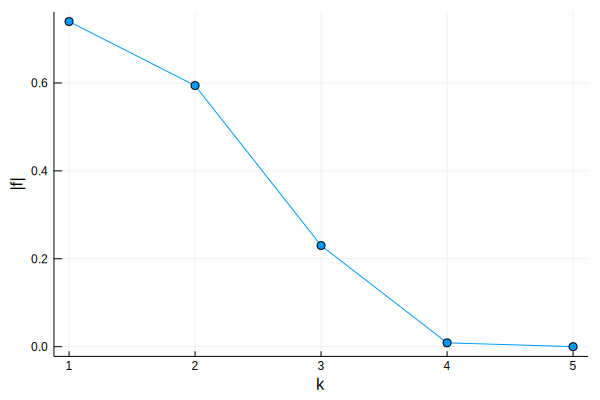

In [12]:
plot(fnorms, shape=:circle, legend = false, xlabel = "k", ylabel = "|f|")

![図18.1](fig18-1.pdf)

図18.1 $f(x)=0$を解くニュートン法の最初の数回の反復．初期値は$x^{(1)}=0.95$．




図18.1に示すように，この方法は非常に早く収束する．しかし，初期値を少し大きく$x^{(1)}=1.15$とするだけで収束しなくなる．

In [13]:
x, fnorms = newton(f,Df,1.15);

In [14]:
f(x)

NaN

In [15]:
fnorms[1:5]

5-element Array{Float64,1}:
   0.8177540779702877
   0.8664056534177534
   0.9735568532451108
   0.9999999999999906
 NaN                 

## 18.3 Levenberg–Marquardt法

ガウス＝ニュートン法はヤコビ行列の列が線形従属の場合には失敗する可能性がある．また$\| f(x^{(k)}) \|$が各反復で減少することも保証されていない．この2つの大きな欠点はLevenberg–Marquardt法で解決できる．以下は本書アルゴリズム18.3のJuliaでの実装である．この関数は`VMLS`パッケージに含まれている．

In [16]:
function levenberg_marquardt(f, Df, x1, lambda1; kmax=100, tol=1e-6)
    n = length(x1)
    x = x1
    lambda = lambda1
    objectives = zeros(0,1)
    residuals = zeros(0,1)
    for k = 1:kmax
         fk = f(x)
         Dfk = Df(x)
         objectives = [objectives; norm(fk)^2]
         residuals = [residuals; norm(2*Dfk'*fk)]
         if norm(2*Dfk'*fk) < tol
             break  
         end;
         xt = x - [ Dfk; sqrt(lambda)*eye(n) ] \ [ fk; zeros(n) ]
         if norm(f(xt)) < norm(fk)
             lambda = 0.8*lambda
             x = xt
         else
             lambda = 2.0*lambda
         end
    end
    return x, Dict([ ("objectives", objectives), ("residuals", residuals) ])
end

levenberg_marquardt (generic function with 1 method)

12行目では本書＊＊＊ページで議論した2つ目の停止条件であり，最適性条件(18.3)が満たされているかどうかをチェックしている．toleranceのデフォルトは$10^{-6}$であるが，これは扱う問題のスケール（値の範囲）と必要な精度に依存する．
覚えておくべきことは，最適性条件(18.3)は必要条件であり
非線形最小二乗問題の目的関数$\| f(x) \|^2$の最適解であることは保証していない，ということである．
このコードの最大反復回数は$k^\mathrm{max}$であり，それ以上の反復はアルゴリズムが収束に失敗した，とみなす．

この関数の返り値は収束までの反復系列の情報を持つ辞書であり，
各反復での$\| f(x^{(k)}) \|^2$と$\| D f(x^{(k)})^T f(x^{(k)}) \|^2$が含まれている．



### 非線形方程式

ではこの関数をスカラー関数(18.1)に対して初期値$x^{(1)}=1.15$で実行してみる．


In [17]:
using VMLS

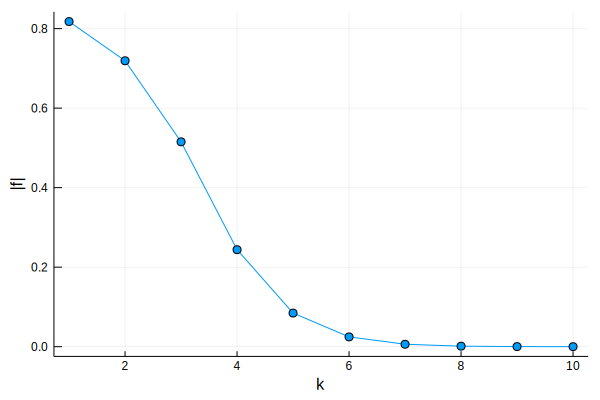

In [18]:
f(x) = (exp.(x) - exp.(-x)) / (exp.(x) + exp.(-x));
Df(x) = 4 ./ (exp.(x) + exp.(-x)).^2;
x, history = levenberg_marquardt(f, Df, [1.15], 1.0);
plot(sqrt.(history["objectives"][1:10]), shape = :circle, legend = false, xlabel = "k", ylabel = "|f|")


![図18.2](fig18-2.pdf)

図18.2 $f(x)=(\exp(x) - \exp(-x)) / (\exp(x) + \exp(-x))$を解くLevenberg–Marquardt法の$| f(x^{(k)}) |$の反復回数$k$に対するプロット．初期値は$x^{(1)}=1.15$と$\lambda^{(1)}=1$．

結果を図18.2に示す．


ここでは，$x^{(1)}$を配列`[1.15]`として引数に与え，`f`と`Df`の定義では引数がベクトルでも適用されるようにドット記法を用いた．Juliaではスカラーと1次元ベクトルが区別されるため，こうすることが必要である．もし関数`levenberg_marquardt`にスカラーの引数`x1`を与えると，Juliaではスカラーから1次元ベクトルを引くことができないため，15行目でエラーが発生する．

### 均衡価格

2つの変数を持つ以下の非線形方程式$f(p) = 0$を解く．
$$
f(p) = \exp(E^\mathrm{s} \log p + s^\mathrm{nom} - \exp(E^\mathrm{d} \log p + d^\mathrm{nom}))  \quad (18.2)
$$
ここで$\exp$と$\log$はベクトルの要素毎に適用されるとみなす．この問題のパラメータは$s^\mathrm{nom}=(2.2, 0.3), d^\mathrm{nom}=(3.1, 3.2)$,
$$
E^\mathrm{s} =
\begin{bmatrix}
0.5 & -0.3 \\
-0.15 & 0.8
\end{bmatrix},
\quad
E^\mathrm{d} =
\begin{bmatrix}
-0.5 & 0.2\\
0 & -0.5
\end{bmatrix}
$$
である．

In [19]:
snom = [2.2, 0.3];
dnom = [3.1, 2.2];
Es = [0.5  -.3; -0.15 0.8];
Ed = [-0.5 0.2; -0.00 -0.5];
f(p) = exp.(Es * log.(p) + snom) - exp.(Ed * log.(p) + dnom);
function Df(p)
S = exp.(Es * log.(p) + snom);
D = exp.(Ed * log.(p) + dnom);
return [ S[1]*Es[1,1]/p[1]  S[1]*Es[1,2]/p[2];
         S[2]*Es[2,1]/p[1]  S[2]*Es[2,2]/p[2] ] -
       [ D[1]*Ed[1,1]/p[1]  D[1]*Ed[1,2]/p[2];
         D[2]*Ed[2,1]/p[1]  D[2]*Ed[2,2]/p[2] ];
end;
p, history = levenberg_marquardt(f, Df, [3, 9], 1);
p

2-element Array{Float64,1}:
 5.644108533416072
 5.265754930531486

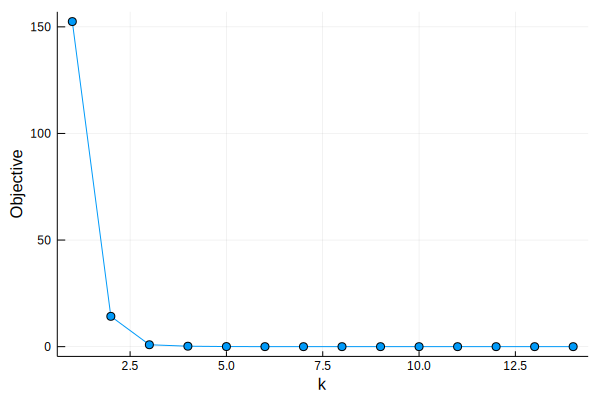

In [21]:
plot(history["objectives"], shape = :circle, legend =false, xlabel = "k", ylabel = "Objective")

![図18.3](fig18-3.pdf)

図18.3 式(18.2)の例題に対するコスト関数$\| f(p^{(k)}) \|^2$の反復回数$k$に対するプロット．


図18.3は反復回数$k$に対する$\| f(p^{(k)}) \|^2$のプロットである．


### 測量

次の例は本書＊＊＊ページの測量問題である．
$m=5$個の点$a_i$の位置が$5 \times 2$行列$A$で与えられる．計測は5次元ベクトル`rhos`である．
関数`f(x)`と`Df(x)`のコードを簡単化するため，距離のベクトル$(\| x - a_1 \|, \ldots, \| x - a_m \|)$を計算する関数`dist(x)`を追加する．ヤコビ行列は以下のものである．
$$
Df(x) =
\begin{bmatrix}
\dfrac{x_1 - (a_1)_1}{\| x - a_1\|} &
\dfrac{x_1 - (a_1)_2}{\| x - a_1\|} \\
\vdots & \vdots \\
\dfrac{x_1 - (a_m)_1}{\| x - a_m\|} &
\dfrac{x_1 - (a_m)_2}{\| x - a_m\|}
\end{bmatrix}
$$
これを計算するには，対角要素が$1/\|x - a_i\|$である対角行列と，
$i,j$要素が$(x - a_i)_j$である$5 \times 2$行列との積を取ればよい．


3つの初期値についてLevenberg–Marquardt法を$\lambda^{(1)}=0.1$として実行した結果を図18.4に示す．

In [22]:
# 5箇所の計測点からなる5x2行列
A = [ 1.8  2.5; 2.0  1.7; 1.5  1.5; 1.5  2.0; 2.5  1.5 ];
# 計測された5箇所の距離ベクトル
rhos = [ 1.87288, 1.23950, 0.53672, 1.29273, 1.49353 ];
# dist(x)は距離||x-ai||からなる5次元ベクトルを返す
dist(x) = sqrt.( (x[1] .- A[:,1]).^2 + (x[2] .- A[:,2]).^2 );
# f(x)は5つの残差を返す
f(x) = dist(x) - rhos;
# Df(x)は5x2ヤコビ行列
Df(x) = diagonal(1 ./ dist(x)) *
          [ (x[1] .- A[:,1])  (x[2] .- A[:,2]) ];
# 初期値(1.8,3.5)とlambda = 0.1で開始
x1, history1 = levenberg_marquardt(f, Df, [1.8, 3.5], 0.1);
x1

2-element Array{Float64,1}:
 1.1824859803827907
 0.8242289367900364

In [23]:
# 初期値を(3.0,1.5)にする
x2, history2 = levenberg_marquardt(f, Df, [3.0, 1.5], 0.1);
x2

2-element Array{Float64,1}:
 1.1824857942435818
 0.8242289466379732

In [24]:
# 初期値を(2.2,3.5)にする
x3, history3 = levenberg_marquardt(f, Df, [2.2, 3.5], 0.1);
x3

2-element Array{Float64,1}:
 2.9852664103617954
 2.1215768036188956

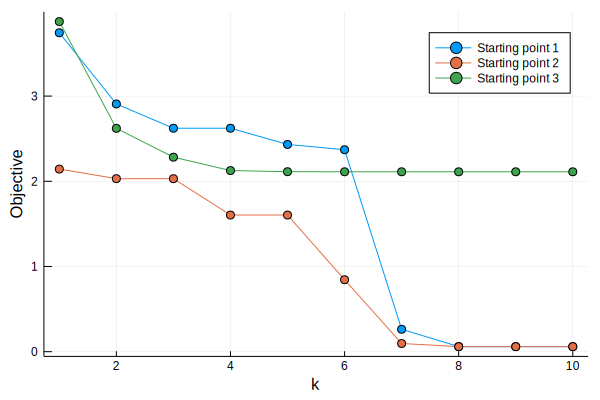

In [25]:
plot(history1["objectives"][1:10], shape = :circle,
     label = "Starting point 1")
plot!(history2["objectives"][1:10], shape = :circle,
      label = "Starting point 2")
plot!(history3["objectives"][1:10], shape = :circle,
      label = "Starting point 3")
plot!(xlabel = "k", ylabel = "Objective")

![図18.4](fig18-4.pdf)

図18.4 測量問題の3つの初期値についての，
反復回数$k$に対する目的関数$\| f(x^{(k)}) \|^2$



## 18.3 非線形モデルの当てはめ

### 例

ここでは次のモデル
$$
\hat{f}(x; \theta) = \theta_1 e^{\theta_2 x} \cos(\theta_3 x + \theta_4)
$$
を$N=60$個のデータ点にフィッティングする．

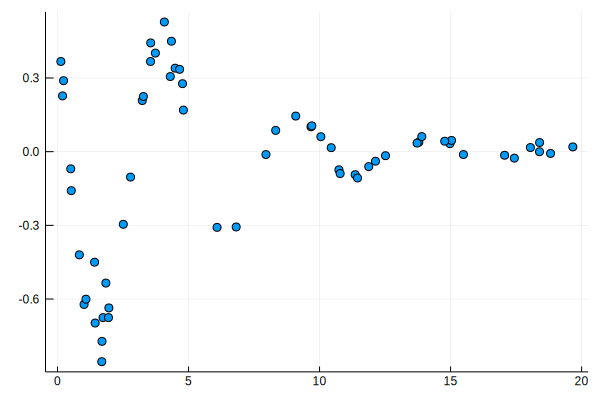

In [27]:
# これらのパラメータでデータを生成する
theta_ex = [1, -0.2, 2*pi/5, pi/3];
# 0から20までの値でxを60点選ぶ
M = 30;
xd = [5*rand(M); 5 .+ 15*rand(M)];
# これらの点で関数を評価
yd = theta_ex[1] * exp.(theta_ex[2]*xd) .*
     cos.(theta_ex[3] * xd .+ theta_ex[4]);
# ydのランダムな置換を生成
N = length(xd);
yd = yd .* (1 .+ 0.2*randn(N)) .+ 0.015 * randn(N);
# データ点をプロット
scatter(xd, yd, legend=false)


60個のデータ点を図18.5に示す．
Levenberg–Marquardt法を，初期値$\theta^{(1)}=(1,0,1,0)$と$\lambda^{(1)}=1$で実行する．
フィッティングされたモデルを図18.5に示す．


In [28]:
f(theta) =  theta[1] * exp.(theta[2]*xd) .*
            cos.(theta[3] * xd .+ theta[4]) - yd;
Df(theta) = hcat(
                 exp.(theta[2]*xd) .* cos.(theta[3] * xd .+ theta[4]),
                 theta[1] * ( xd .* exp.(theta[2]*xd) .*
                     cos.(theta[3] * xd .+ theta[4])),
                 -theta[1] * ( exp.(theta[2]*xd) .* xd .*
                     sin.(theta[3] * xd .+ theta[4])),
                 -theta[1] * ( exp.(theta[2]*xd) .*
                     sin.(theta[3] * xd .+ theta[4])) );
theta1 = [1, 0, 1, 0];
theta, history = levenberg_marquardt(f, Df, theta1, 1.0);
theta

4-element Array{Float64,1}:
  0.9771359091783434 
 -0.19408917471611328
  1.2704959645478318 
  1.0318388254787374 

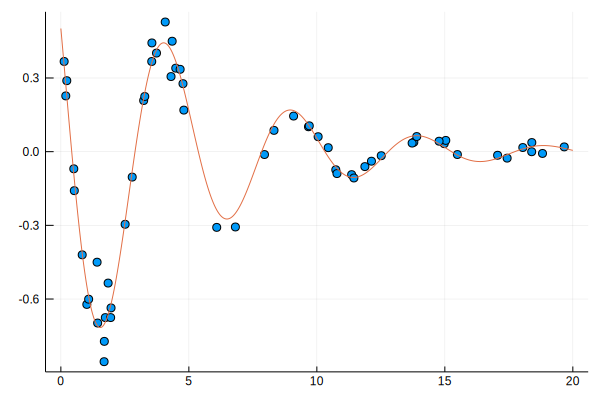

In [29]:
# 当てはめたモデルをプロット
x = linspace(0, 20, 500);
y=theta[1]*exp.(theta[2]*x) .* cos.(theta[3]*x .+ theta[4]);
plot!(x, y, legend = false)


![図18.5](fig18-5.pdf)

図18.5 $N=60$個の点$(x^{(i)}, y^{(i)})$に対して関数$\hat{f}(x; \theta) = \theta_1 e^{\theta_2 x} \cos(\theta_3 x + \theta_4)$を最小二乗法でフィッティングした結果


### 直交距離回帰

本書の図18.14では3次多項式
$$
\hat{f}(x; \theta) = \theta_1 + \theta_2 x + \theta_3 x^2 + \theta_4 x^3
$$
を，$N=25$個のデータ点にフィッティンする．

まずデータを読み込み標準的な最小二乗法でフィッティングしてみる．

In [30]:
xd, yd = orth_dist_reg_data();  # 長さN = 25の2次元ベクトル
N = length(xd);
p = 4;
theta_ls = vandermonde(xd, p) \ yd;

本書＊＊＊ページの非線形最小二乗法には$p + N$個の変数$\theta_1, \ldots, \theta_p, u^{(1)}, \ldots, u^{(N)}$がある．
これらの変数を非線形最小二乗法のベクトル変数になる順番で格納する．
目的関数は以下の$2N$次元ベクトルのノルムの二乗である．
$$
\begin{bmatrix}
\hat{f}(u^{(1)}; \theta) - y^{(1)} \\
\vdots\\
\hat{f}(u^{(N)}; \theta) - y^{(N)} \\
u^{(1)} - x^{(1)} \\
\vdots\\
u^{(N)} - x^{(N)}
\end{bmatrix}
$$

In [31]:
function f(x)
    theta = x[1:p];
    u = x[p+1:end];
    f1 = vandermonde(u,p)*theta - yd
    f2 = u - xd
    return [f1; f2]
end;
function Df(x)
    theta = x[1:p]
    u = x[p+1:end]
    D11 = vandermonde(u,p)
    D12 = diagonal(theta[2] .+ 2*theta[3]*u .+ 3*theta[4]*u.^2)
    D21 = zeros(N,p)
    D22 = eye(N)
    return [ D11 D12; D21 D22]
end;

この2つの関数を引数にして`levenberg_marquardt`を呼び出す．
初期値として適当なものは，変数$\theta$については最小二乗解，変数$u^{(i)}$についてはデータ点$x^{(i)}$である．
ここでは$\lambda^{(1)}=0.01$とする．


In [32]:
sol, hist = levenberg_marquardt(f, Df, [theta_ls; xd], 0.01);
theta_od = sol[1:p];

フィッティングした2つのプロットを図18.6に示す．

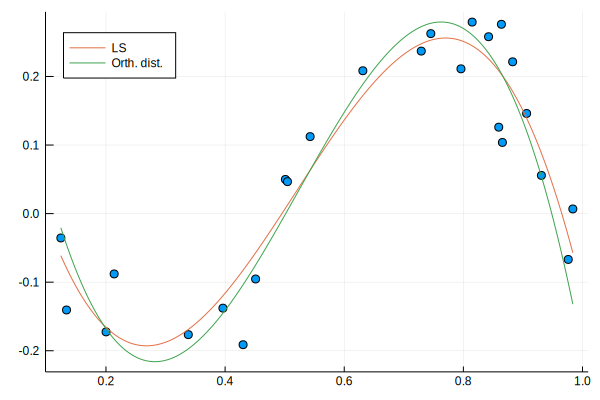

In [40]:
scatter(xd,yd, label="", legend = :topleft);
x = linspace(minimum(xd), maximum(xd), 500);
function penalty_method(f, Df, g, Dg, x1, lambda1; kmax = 100,
            feas_tol = 1e-4, oc_tol = 1e-4)
x = x1
mu = 1.0
feas_res = [norm(g(x))]
oc_res = [norm(2*Df(x)'*f(x) + 2*mu*Dg(x)'*g(x))] 
lm_iters = zeros(Int64,0,1);
for k=1:kmax
  F(x) = [f(x); sqrt(mu)*g(x)]
  DF(x) = [Df(x); sqrt(mu)*Dg(x)]
  x, hist = levenberg_marquardt(F,DF,x,lambda1,tol=oc_tol)
  feas_res = [feas_res; norm(g(x))]
  oc_res = [oc_res; hist["residuals"][end]]
  lm_iters = [lm_iters; length(hist["residuals"])]
  if norm(g(x)) < feas_tol
    break
  end
  mu = 2*mu
end
return x, Dict([ ("lm_iterations", lm_iters),
         ("feas_res", feas_res), ("oc_res", oc_res) ])
end
y_ls = vandermonde(x, p) * theta_ls;
y_od = vandermonde(x, p) * theta_od;
plot!(x, y_ls, label = "LS")
plot!(x, y_od, label = "Orth. dist.")




![図18.6](fig18-6.pdf)

図18.6 25個のデータ点に対して3次多項式を最小二乗法とorthogonal distance regressionでフィッティングした結果



## 18.5 非線形最小二乗識別
